# Notebook for survival modelling with Wave-LSTM

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [1]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
from IPython.display import display, HTML
import umap
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
from matplotlib import colors
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette

import TCGA
from WaveletVAE.src.WaveLSTM.models.base import WaveletBase

# Plotting set up
sns.set()
sns.set_palette(pallette.mpl_colors)
cmap = plt.cm.Blues
norm = colors.BoundaryNorm(np.arange(-0.5, 8.5, 1), cmap.N)

# %matplotlib notebook

Global seed set to 42
Global seed set to 42
Global seed set to 42


# Get data

In [2]:
# Load data
cancer_types = ['THCA', 'BRCA', 'OV', 'GBM', 'HNSC']
dm = TCGA.data_modules.ascat.loaders.ASCATDataModule(batch_size=256, cancer_types=cancer_types,
                                                     chrom_as_channels=True,
                                                     sampler=False)

# Labels are encoded in a different order
label_dictionary = {0: 'BRCA', 1: 'GBM', 2: 'HNSC', 3: 'OV', 4: 'THCA'}
labels = [label_dictionary[i] for i in label_dictionary.keys()]
print(labels)

['BRCA', 'GBM', 'HNSC', 'OV', 'THCA']


## Consolodate batches and view class counts
Collect training, validation, and test features and labels

In [3]:
data, counts = [], []
for set_name, loader in zip(["Train", "Validation", "Test"], [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]):
    print("\n" + set_name + " set \n" + "="*(len(set_name) + 4))
    
    # Combine batches, pulling out the information we want 
    features, lbls = [], []
    genders = []
    for batch in iter(loader):
        features.append(batch["feature"])
        lbls.append(batch["label"])
        genders.append(batch["sex"])
    data.append({"feature": torch.concat(features, 0).numpy().reshape((-1, 2, 23, 256)),
                 "label": torch.concat(lbls, 0).numpy(),
                 "gender": np.concatenate(genders)}
               )
    
    # Report count of each clone 
    print(f"{data[-1]['feature'].shape[0]} samples composed of")
    count = []
    for lbl, cnt in zip(*np.unique(data[-1]['label'], return_counts=True)):
        print(f"{label_dictionary[lbl]} with count {cnt}")
        count.append(cnt)
    counts.append(count)


Train set 
2416 samples composed of
BRCA with count 794
GBM with count 411
HNSC with count 397
OV with count 414
THCA with count 400

Validation set 
302 samples composed of
BRCA with count 104
GBM with count 46
HNSC with count 51
OV with count 57
THCA with count 44

Test set 
303 samples composed of
BRCA with count 100
GBM with count 45
HNSC with count 55
OV with count 61
THCA with count 42


## Heavy tailed feature counts

This dataset is contains cells which are significantly mutated, with counts number alterations ranging much higher with a heavy right-tail.

Text(0.5, 0, 'Count number alterations')

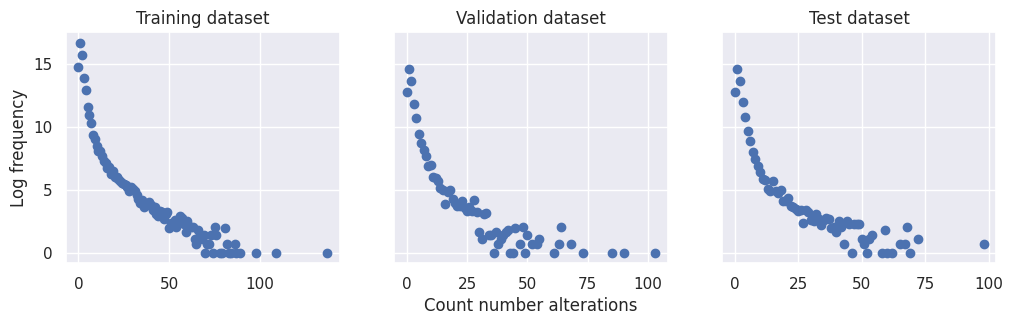

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,3))
for i, dset in enumerate(["Training", "Validation", "Test"]):
    count, freq = np.unique(data[i]['feature'], return_counts=True)
    axes[i].scatter(count, np.log(freq), c='b')
    axes[i].set_title(dset + " dataset")
axes[0].set_ylabel("Log frequency")
axes[1].set_xlabel("Count number alterations")

# Section 1: Visualisation of CNA data

Select which data set we want to visualise in this section of the notebook, and which chromosome and strand to highlight.

     

In [5]:
subset = 0           # 0=train set, 1=validation set, 2=test set
chromosome = 23       # 1,...,23 (where 23 is the sex autosome X/Y)
strand = 2           # 1=major or 2=minor

Define plotting functions

In [6]:
def plot_chromosomes(features, 
                     xlabel="Chromosomes",
                     ylabel="Cancer cell samples",
                     splits=None, 
                     figsize=(15,5)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 24):
        plt.axvline(x=(_chrom-1)*dm.W, color='k', alpha=0.25)
    # Horizontal lines: separating cancers
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(labels)
        
    plt.ylabel(ylabel)
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * dm.W for _chrom in range(23)])
    ax.set_xticklabels(["X/Y" if _chrom == 23 else _chrom for _chrom in range(1,24)], rotation=0)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.set_ticklabels([i for i in range(7)] + ["7+"])
    colorbar.minorticks_off() 
    
def plot_chromosome(features, 
                    xlabel="Loci",
                    ylabel="Cancer cell samples",
                    splits=None, 
                    figsize=(8,5)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Horizontal lines: separating cancers
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(labels)
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0,8))
    colorbar.set_ticklabels([i for i in range(7)] + ["7+"])
    colorbar.minorticks_off() 

## Plot chosen set, and zoom in on a selected chromosome and strand

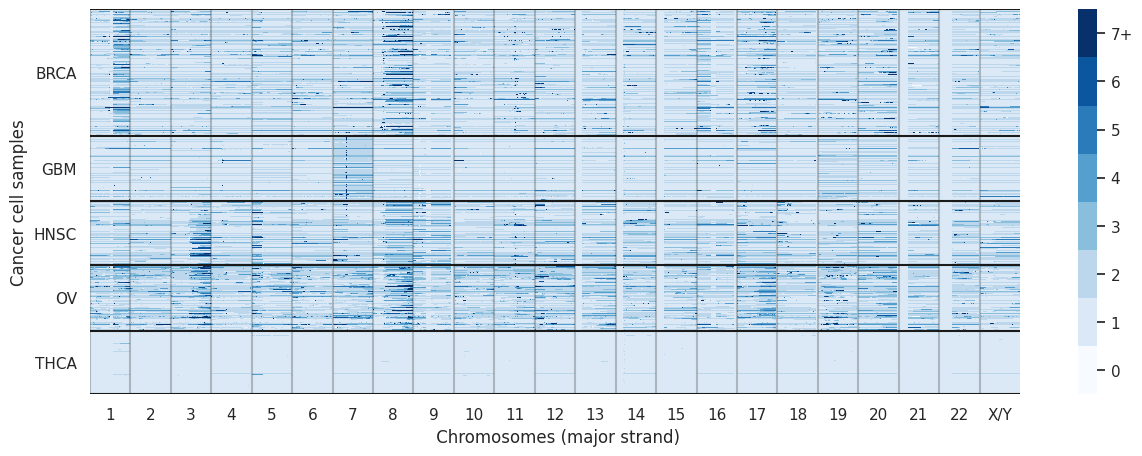

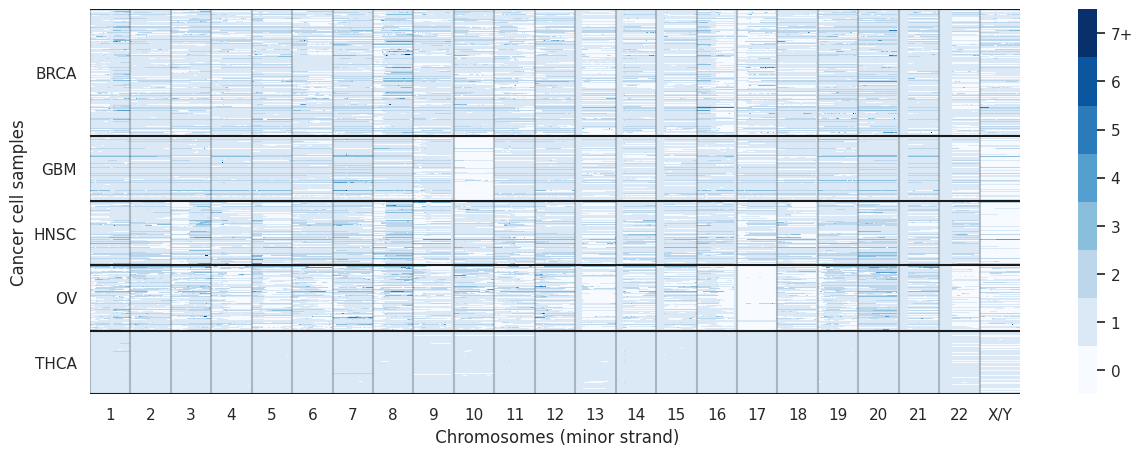

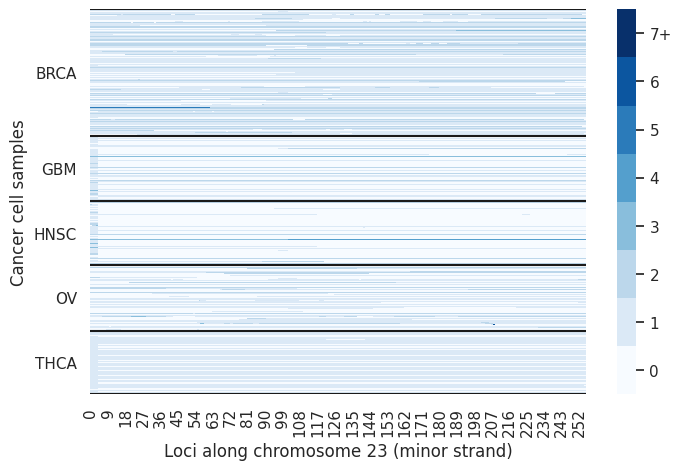

In [7]:
label_order = np.argsort(data[subset]["label"])
splits = np.insert(np.cumsum(counts[subset]), 0, 0)

# All chromosomes
for _strand in range(1,3):
    features = data[subset]["feature"][label_order, _strand-1, :, :].reshape((-1, 23*256))
    
    plot_chromosomes(features, 
                     splits=splits,
                     xlabel=f" Chromosomes ({'major' if _strand == 1 else 'minor'} strand)"
                    )
    plt.savefig(f"{'Major' if _strand == 1 else 'Minor'}Strand.png", dpi=500, format='png', transparent=False)
    
    
# Single chromosome
plot_chromosome(data[subset]["feature"][label_order, strand-1, chromosome-1, :],
                splits=splits,
                xlabel=f"Loci along chromosome {chromosome} ({'major' if strand == 1 else 'minor'} strand)")
plt.savefig(f"{'Major' if _strand == 1 else 'Minor'}Strand_Chr{chromosome}.png", dpi=500, format='png', transparent=False)


# Section 2: Model visualisations (test set)

Additional visualisations are also created at run-time with WandB logging, and can be viewed separately.


# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

    J = 1
         "../logs/desurv_J1R1_1.pkl"
    J = 3
         "../logs/desurv_J3R1_1.pkl"
         "../logs/desurv_J3R5_1.pkl"
    J = 5
         "../logs/desurv_J5R1_1.pkl"
         "../logs/desurv_J5R5_1.pkl"
         "../logs/desurv_J5R10_1.pkl"


In [8]:
log_name = "J5R10_1"
with open(f"../logs/desurv_{log_name}.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
M = meta_results["M"]
A = meta_results["attention"]

print(f"Available meta data keys")
for _key in meta_results.keys():
    print(f" * '{_key}'")


Available meta data keys
 * 'scaled_masked_inputs'
 * 'scaled_masked_targets'
 * 'resolution_embeddings'
 * 'attention'
 * 'M'
 * 'ode_input'
 * 'labels'


## Section 2.1: Visualise Wave-LSTM encoder output

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

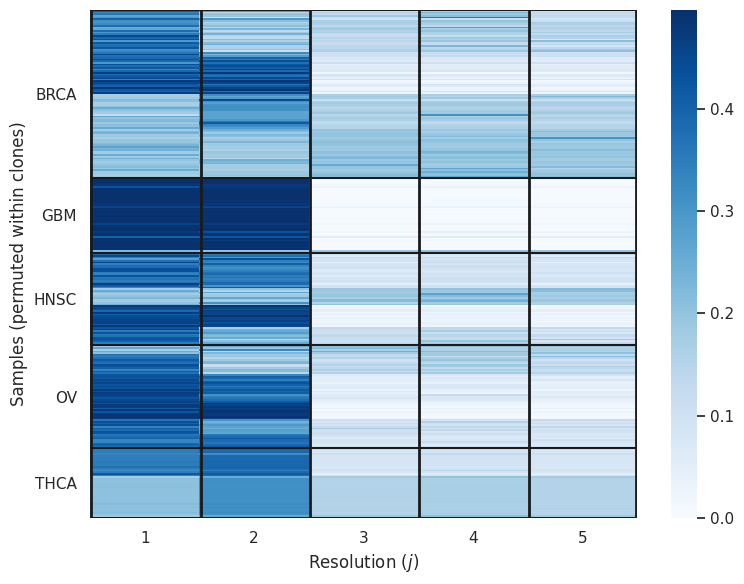

In [9]:
# The number of sub-clusters to split each clone into  
num_clusters = [4, 2, 4, 6, 2]                    # A more appropriate choice
# num_clusters = [2, 2, 2, 2, 2]                      # Coarser sub-groups

Abar = torch.mean(A, dim=1).cpu().numpy()

# Nested ordering (by biclustering attention)
atn_order = []
for idx_cancer in range(5):
    lbl_idx = np.where(data[-1]["label"] == idx_cancer)[0]
    atn_clone = Abar[lbl_idx, :]
    clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=np.min((num_clusters[idx_cancer], atn_clone.shape[0])))
    clustering.fit(atn_clone)
    permute_idx = np.argsort(clustering.labels_)
    atn_order.append(lbl_idx[permute_idx])
atn_order = np.concatenate(atn_order)

# Make permuted attention plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(Abar[atn_order, :], ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1
# Split clones
splits = np.insert(np.cumsum(counts[-1]), 0, 0)
for split in splits:
    plt.axhline(y=split, color='k', linestyle='-')
ax.set_yticks((splits[1:] + splits[:-1])/2)
ax.set_yticklabels(labels)
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)    
# Split resolutions
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
ax.vlines(x=Abar.shape[1]-0.01, ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
# 
ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Samples (permuted within clones)")    # permuted
plt.ylim((splits[-1], 0, ))
plt.tight_layout()
plt.savefig(f"{log_name}/attention.png", dpi=500, format='png', transparent=False)

## Visualise test features, permuted by attention

Plot test CNA features, permuted by the same order as attention above

Select which chromosome and strand to highlight.

In [10]:
chromosomes = [23, 23]        # 1,...,23
strands = [1, 2]              # major=1, or minor=2
assert len(chromosomes) == len(strands)

/tmp/ipykernel_350884/1784547746.py:49: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



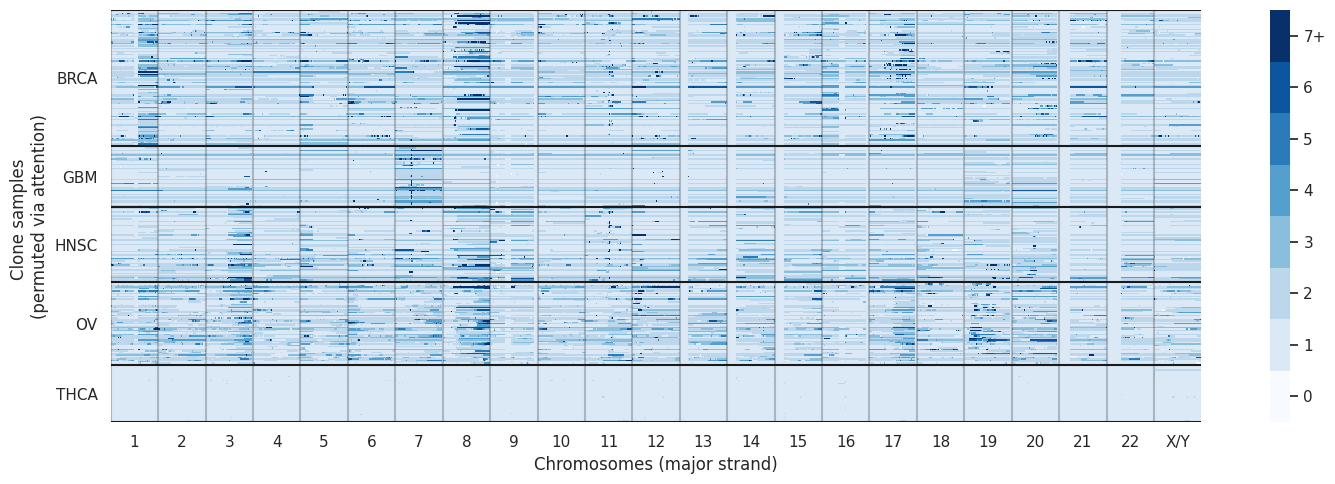

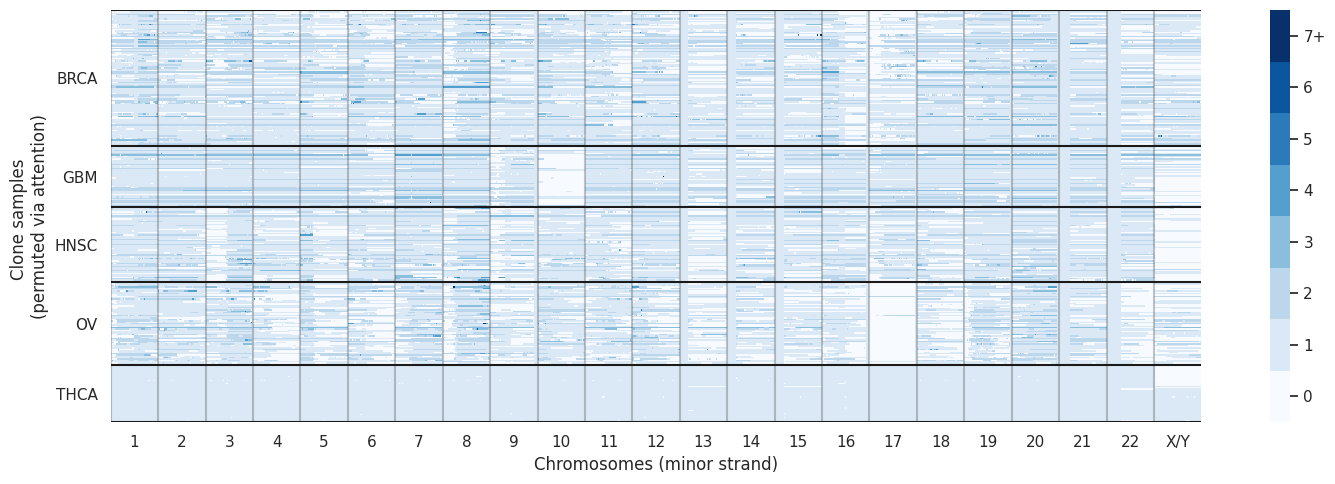

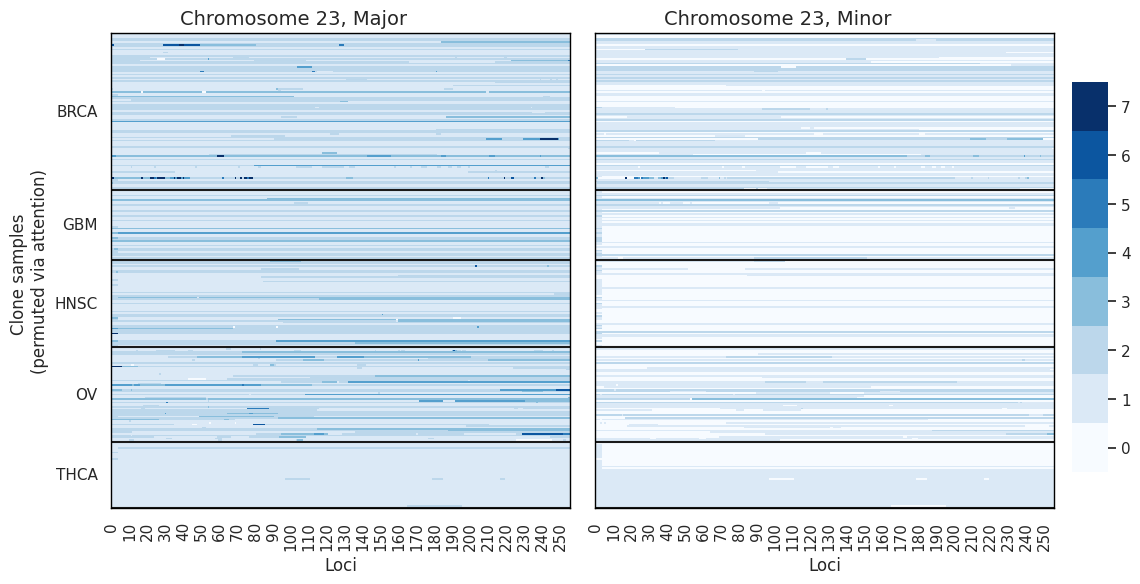

In [21]:
test_features = data[-1]["feature"] 

splits = np.insert(np.cumsum(counts[-1]), 0, 0)    

# Stacked channels
for _strand in range(1,3):
    
    plot_chromosomes(test_features[atn_order, _strand-1, :, :].reshape((-1, 23*256)),
                    splits=splits,
                    xlabel=f"Chromosomes ({'major' if _strand == 1 else 'minor'} strand)",
                    ylabel="Clone samples \n(permuted via attention)",
                    )
    plt.tight_layout()
    plt.savefig(f"{log_name}/PermuteAttention_Strand{'Major' if _strand == 1 else 'Minor'}.png", dpi=500, format='png', transparent=False)
    
    
# Zoom in
fig, axes = plt.subplots(1, len(chromosomes), figsize=(12,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.9, .2, .03, .65])
for idx, ax in enumerate(axes):
    sns.heatmap(test_features[atn_order, strands[idx]-1, chromosomes[idx]-1, :], ax=ax, cmap=cmap, norm=norm, yticklabels=True, 
                cbar=idx == len(strands)-1, cbar_ax=cbar_ax if idx == len(strands)-1 else None)

    # Horizontal lines: separating sub-clusters
    for split in splits:
        ax.axhline(y=split, color='k', linestyle='-')
    
    # X-axis
    ax.set_xlabel(f"Loci")
    ax.set_xlim((0,dm.W))
    # Manually specify colorbar labelling after it's been generated
    if idx == len(strands)-1:
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.arange(0, 8))
        colorbar.minorticks_off() 

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.15, 1.05, f"Chromosome {chromosomes[idx]}, {'Major' if strands[idx]-1 == 0 else 'Minor'}", ha='left', va='top', transform=ax.transAxes, size=14)
 
# Y-axis
axes[0].set_yticks((splits[1:] + splits[:-1])/2)
axes[0].set_yticklabels(labels)
axes[0].set_ylabel(f"Clone samples \n(permuted via attention)", loc="center")

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f"{log_name}/PermuteAttention_SubTHCA.png", dpi=500, format='png', transparent=False)

We note that the major split within HNSC is on the sex chromosome (X/Y). We'd expect this to then be a consequence having a population with both male and female. Extracting the genders (ordered from top to bottom of the above plot) we confirm this

In [12]:
print(list(data[-1]["gender"][atn_order][-counts[-1][-1]:]))

['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female']


# Visualise Wave-LSTM encoder output

In [13]:
# First, just create instance of whatever reducer we want to use

reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=1, learning_rate='auto', init='random', perplexity=20)
else:
    raise NotImplementedError

# axis labels
proj1_label = f"{reduce_method}-1"

## Visualise resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

Create reducer. 

Note, there is a large imbalance in representation so the perplexity must be chosen to compromise between preserving local structures for under represented clones and the global structures of the larger clones.

In [14]:
data_res_emb = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["scaled_masked_inputs"][j_res].cpu().numpy()

    # Projection of source separated input
    x_j = x_j.reshape((x_j.shape[0], -1))                # Reshape x_j to flatten channels
    x_j_proj = StandardScaler().fit_transform(x_j)       # Scale before any transform
    
    for val, val_name in zip([h_j, x_j_proj], ["h_j", "X_j"]):
        for i in range(val.shape[0]):
            data_res_emb.append([i, 
                                 val[i, 0], 
                                 val_name,
                                 j_name, 
                                 labels[data[-1]["label"][i]],
                                ])  

df_res_emb = pd.DataFrame(data_res_emb, columns=["sample", proj1_label, "source", "resolution", "Cancer"])
display(df_res_emb)

,sample,tSNE-1,source,resolution,Cancer
0,0,1.738106,h_j,1,GBM
1,1,1.725047,h_j,1,GBM
2,2,2.299731,h_j,1,GBM
3,3,1.273284,h_j,1,OV
4,4,1.844554,h_j,1,GBM
...,...,...,...,...,...
3025,298,0.064839,X_j,5,HNSC
3026,299,0.064839,X_j,5,HNSC
3027,300,-0.328580,X_j,5,HNSC
3028,301,-0.328580,X_j,5,HNSC


Choose which subset to view

In [15]:
resolutions = [1,2,3,4,5]                 # 1,..., J
source = "h_j"                            # Source separated input and/or resolution embeddings. 
                                          #    "X_j" for input, but HNSC is very peaked so I suggest removing this class from the plot
cancers = ['THCA', 'BRCA', 'OV', 'GBM', 'HNSC']   # Choose to zoom into cancers

/home/ubuntu/.pyenv/versions/waveLSTM/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



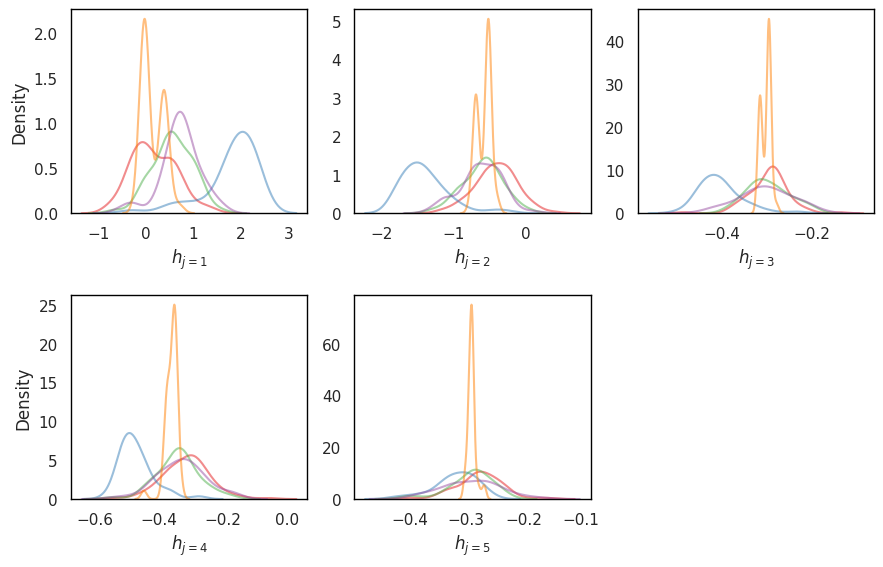

In [16]:
# Plot 
df_fig2 = df_res_emb[df_res_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin([source])]
df_fig2 = df_fig2[df_fig2["Cancer"].isin(cancers)]           # Zoom into subset of classes
# display(df_fig2)

g = sns.FacetGrid(df_fig2, col="resolution",  hue="Cancer", hue_order=labels, col_wrap=3,
                  margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, f"{reduce_method}-1", alpha=0.5)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
if False:
    g.add_legend()
    leg = g._legend
    leg.set_bbox_to_anchor([0.7, 0.4])
    leg._loc = 2 

g.set_xlabels(label="h_j", clear_inner=True)
g.set_ylabels(label="Density", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in [source]] 
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    # ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)
    ax.set_xlabel(f"{space}")

# # Adjust margins
g.figure.subplots_adjust(wspace=0.2, hspace=0.4)
        
plt.savefig(f"{log_name}/ResolutionEmbeddings.png", dpi=500, format='png', transparent=False)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

In [17]:
Mbar = torch.mean(M, axis=1).cpu().numpy().reshape((M.shape[0], -1))

# Construct dataframe
data_mres_emb = []
for i in range(Mbar.shape[0]):
    data_mres_emb.append([i,
                          Mbar[i, 0],
                          "Mbar",
                          labels[data[-1]["label"][i]]
                         ])  
df_mres_emb = pd.DataFrame(data_mres_emb, columns=["sample", proj1_label, "source", "Cancer"])
display(df_mres_emb)

,sample,tSNE-1,source,Cancer
0,0,0.218470,Mbar,GBM
1,1,0.147056,Mbar,GBM
2,2,0.269968,Mbar,GBM
3,3,0.078235,Mbar,OV
4,4,0.176484,Mbar,GBM
...,...,...,...,...
298,298,-0.173260,Mbar,HNSC
299,299,-0.123319,Mbar,HNSC
300,300,-0.237375,Mbar,HNSC
301,301,0.277871,Mbar,HNSC


/home/ubuntu/.pyenv/versions/waveLSTM/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/tmp/ipykernel_350884/146021253.py:24: UserWarning:

The figure layout has changed to tight



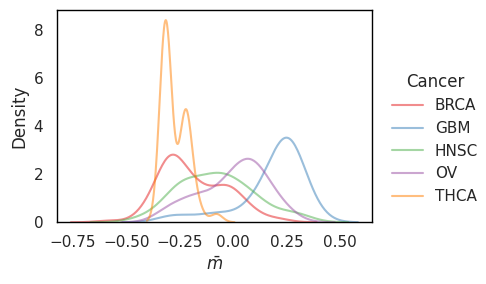

In [22]:
g = sns.FacetGrid(df_mres_emb, col="source", hue="Cancer", hue_order=labels,
                  margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, f"{reduce_method}-1", alpha=0.5)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")

g.add_legend()
leg = g._legend
leg.set_bbox_to_anchor([0.95, 0.75])
leg._loc = 2 

g.set_titles(col_template="", row_template="")    # {row_name}

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))
    ax.set_xlabel(r"$\bar{m}$")

# Adjust margins
plt.tight_layout()
        
plt.savefig(f"{log_name}/MultiResolutionEmbedding.png", dpi=500, format='png', bbox_inches='tight', transparent=False)

## How clusters in resolution space look in feature space

i.e. what features are certain resolutions making distinctions upon.

In [19]:
# Which latent space we wish to visualise
j = 1
cancer = "THCA"

# Which strand and chromosome to zoom into
chromosome = 23       # 1,...,23

# Some suggestions based on resolution plots above
if cancer == "THCA" or cancer == "BRCA":
    num_clusters = 2
elif cancer == "GBM":
    num_clusters = 3
else:
    num_clusters = 1

/tmp/ipykernel_350884/63025169.py:74: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



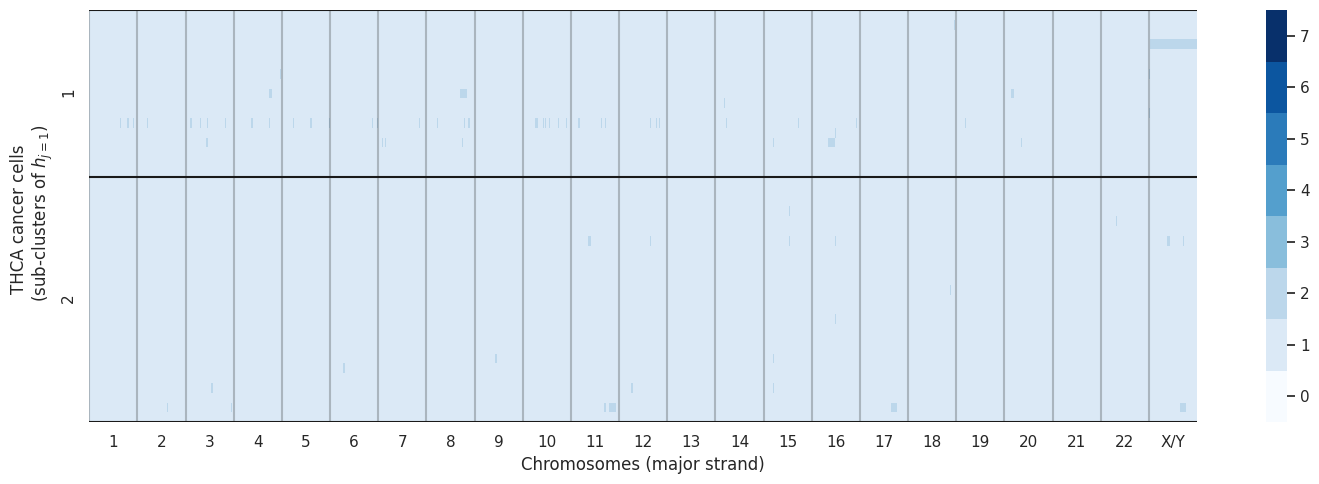

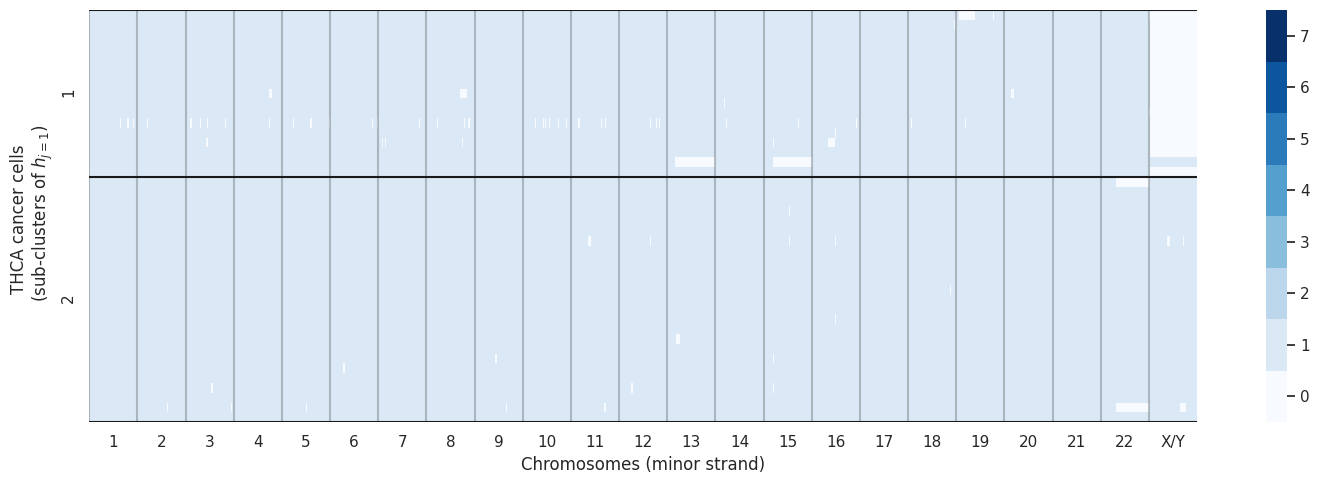

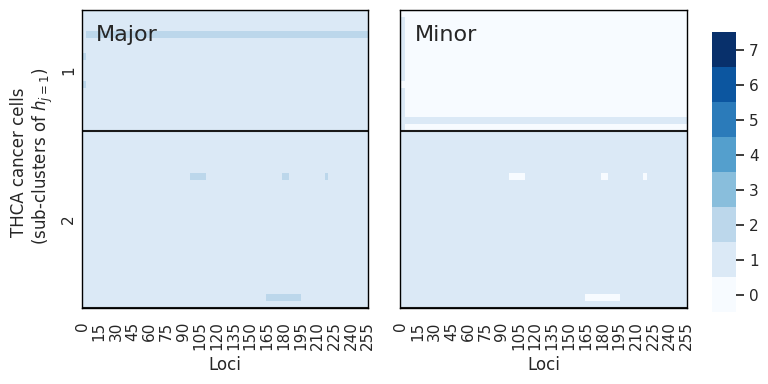

In [20]:
df_res_emb_cluster = df_res_emb[(df_res_emb["source"]=="h_j") & 
                                (df_res_emb["Cancer"]==cancer) & 
                                (df_res_emb["resolution"] == str(j))
                                 ]
features = data[-1]["feature"][df_res_emb_cluster["sample"], :, :, :]
# display(df_res_emb_cluster)

clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters)
clustering.fit(df_res_emb_cluster[[proj1_label]])
permute_idx = np.argsort(clustering.labels_)
sub_counts = [len(np.where(clustering.labels_==i)[0]) for i in range(num_clusters)]

# Stacked channels
for _strand in range(1,3):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    sns.heatmap(features[permute_idx, _strand-1, :, :].reshape((-1, 23*256)), 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 24):
        plt.axvline(x=(_chrom-1)*dm.W, color='k', alpha=0.25)
    # Horizontal lines: separating sub-clusters
    splits = np.insert(np.cumsum(sub_counts), 0, 0)
    for split in splits:
        plt.axhline(y=split, color='k', linestyle='-')
    # Label y-axis
    ax.set_yticks((splits[1:] + splits[:-1])/2)
    ax.set_yticklabels([f"{i+1}" for i in range(num_clusters)], rotation=90)
    plt.ylim((len(permute_idx), 0, ))
    plt.ylabel(f"{cancer} cancer cells \n (sub-clusters of $h{tmp1}{j}{tmp2}$)")
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * dm.W for _chrom in range(23)])
    ax.set_xticklabels(["X/Y" if _chrom == 23 else _chrom for _chrom in range(1,24)], rotation=0)
    plt.xlabel(f"Chromosomes ({'major' if _strand == 1 else 'minor'} strand)")
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.set_ticklabels([i for i in range(8)])
    colorbar.minorticks_off() 
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"{log_name}/Cancer{cancer}_{num_clusters}Subclusters_hj{j}_strand{_strand}.png", dpi=500, format='png', transparent=False)   
        
    
# Zoom in
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.9, .2, .03, .7])
splits = np.insert(np.cumsum(sub_counts), 0, 0)
for strand, ax in enumerate(axes):
    sns.heatmap(features[permute_idx, strand, chromosome-1, :], ax=ax, cmap=cmap, norm=norm, yticklabels=True, 
                cbar=strand == 0, cbar_ax=None if strand else cbar_ax)
    # Horizontal lines: separating sub-clusters
    for split in splits:
        ax.axhline(y=split, color='k', linestyle='-')
    # X-axis
    ax.set_xlabel(f"Loci")
    ax.set_xlim((0,dm.W))
    # Manually specify colorbar labelling after it's been generated
    if not strand:
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.arange(0, 8))
        colorbar.minorticks_off() 
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, f"{'Major' if strand == 0 else 'Minor'}", ha='left', va='top', transform=ax.transAxes, size=16)

# # Y-axis
axes[0].set_yticks((splits[1:] + splits[:-1])/2)
axes[0].set_yticklabels([f"{i+1}" for i in range(num_clusters)], rotation=90, fontdict={'horizontalalignment': "center"})   # \n (sub-clusters of $h{tmp1}{j}{tmp2}$)
axes[0].set_ylabel(f"{cancer} cancer cells \n (sub-clusters of $h{tmp1}{j}{tmp2}$)", loc="center")
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f"{log_name}/Cancer{cancer}_{num_clusters}Subclusters_hj{j}_Chr{chromosome}.png", dpi=500, format='png', transparent=False)   